## 📦 Packaging Center Dataset – Overview

This project focuses on analyzing data collected from multiple agricultural packaging centers.  
Each record represents the daily operational status of a single center.

---

## 🧩 Features

- **product_type** – Type of product being packaged  
- **region** – Geographical area of the center  
- **line_speed** – Packaging line productivity  
- **workers_active** – Number of active workers  
- **energy_usage** – Machine energy consumption  
- **waste_amount** – Amount of daily waste  
- **package_weight_avg** – Average package weight  
- **machine_vibration** – Vibration level of machinery  

---

## 🎯 Target Variable

- **disruption_flag** 
  - `1` → A disruption occurred  
  - `0` → Normal operating day  

---

## Data Characteristics

- Mix of **numeric** and **categorical** values  
- Skewed distributions 
- Contains moderate outliers 
- Suitable for binary classification models 

In [66]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier , RandomForestClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from imblearn.over_sampling import SMOTENC

In [33]:
data = pd.read_csv('packaging_center_records.csv')
pd.set_option('display.width',1000)
print(data.head(5).round(2),'\n')              # Display the first 5 rows of the dataset
print(data.shape,'\n')                         # Display the number of rows and columns in the dataset
print(data.describe().round(2),'\n')           # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)
print(data.groupby('disruption_flag').size())  # Grouping data by target to check distribution

  product_type region  line_speed  workers_active  energy_usage  waste_amount  package_weight_avg  machine_vibration  disruption_flag
0        Apple   West       11.52              34        498.26          5.75                1.92               2.17                0
1       Carrot   East        7.24              16        308.67          1.71                1.40               6.90                0
2        Apple  North       18.07              23        625.56          5.68                2.02               2.13                0
3       Potato  South        8.71              24        231.80          6.08                1.95               5.10                0
4     Cucumber  North       13.64              22        342.00          5.34                1.73               2.64                0 

(987, 9) 

       line_speed  workers_active  energy_usage  waste_amount  package_weight_avg  machine_vibration  disruption_flag
count      987.00          987.00        987.00        987.00    

## 🔧 Preparing the Dataset for Visualizations

Before creating visualizations such as histograms, density plots, boxplots, or heatmaps,  
it is necessary to separate numeric features from categorical (string) features.

### Why Remove String Columns?

Statistical plots require numeric data because:

- Histograms and Density Plots show numerical distributions 📊  
- Boxplots display numerical spread and outliers 📦  
- Heatmaps rely on numerical correlations 🔥  

String-based features (e.g., product names or regions) cannot be interpreted by these plots  
and must be excluded from the visualization dataset.

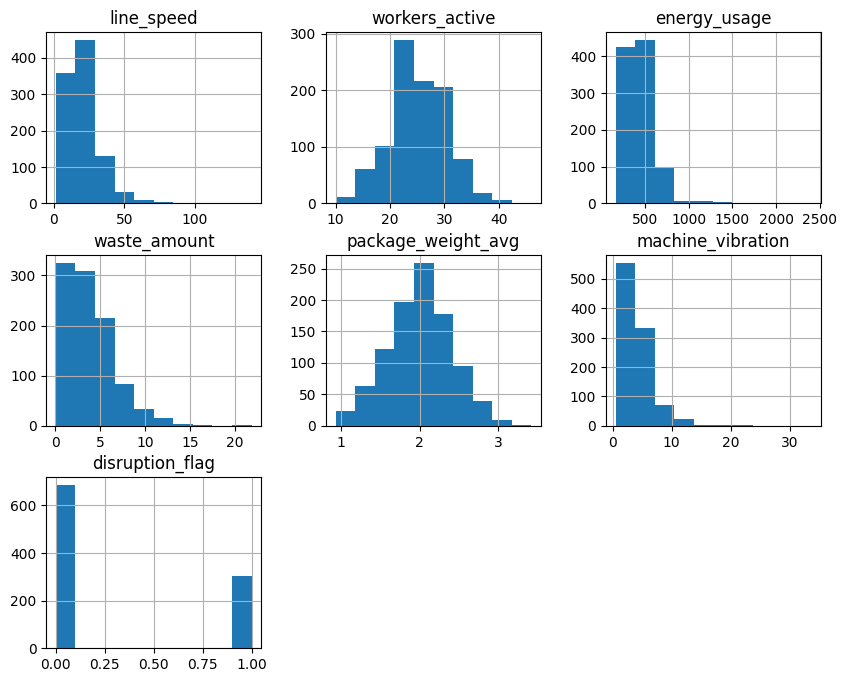

In [34]:
numeric_data = data.select_dtypes(include=['number'])
# Histogram
numeric_data.hist(figsize=(10,8))
plt.show()

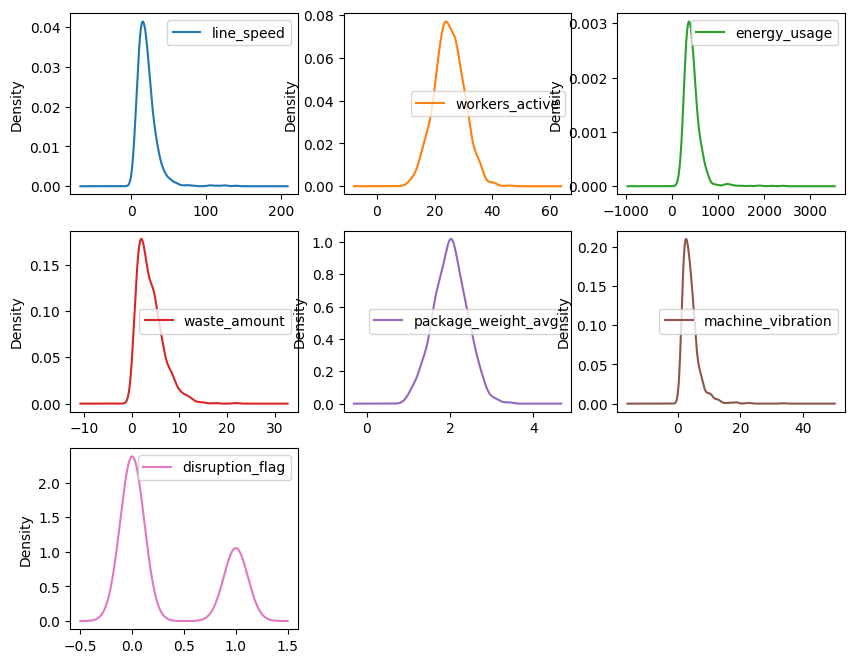

In [35]:
# Density
numeric_data.plot(kind='density',subplots=True,layout=(3,3),sharex=False,figsize=(10,8))
plt.show()

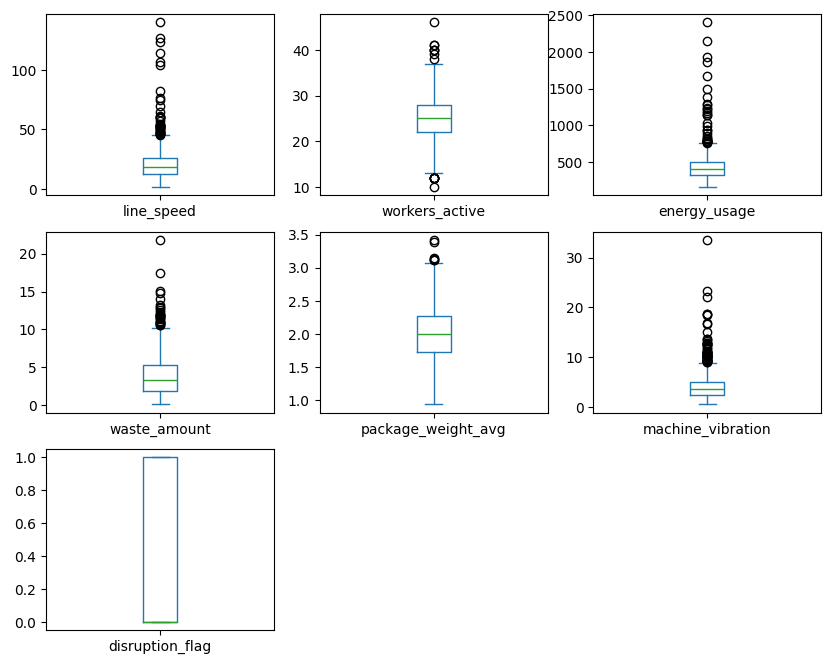

In [36]:
# Boxplot
numeric_data.plot(kind='box',subplots=True,layout=(3,3),sharex=False,figsize=(10,8))
plt.show()

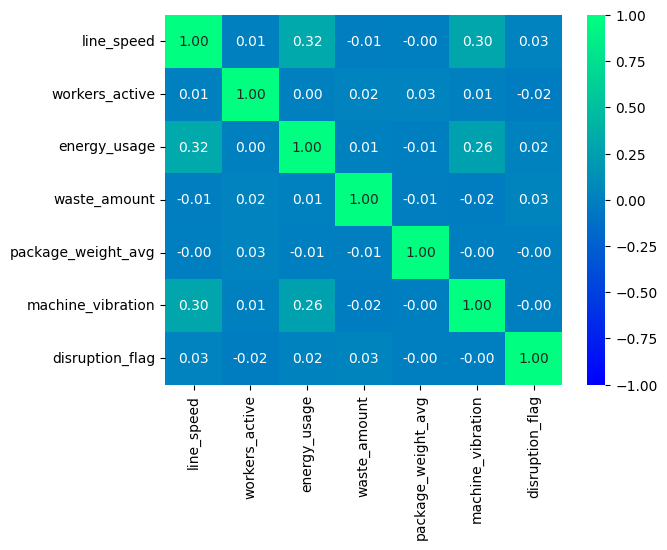

In [37]:
# Hitmap
sns.heatmap(numeric_data.corr(),vmin=-1,vmax=1,cmap='winter',annot=True,fmt='.2f')
plt.show()

## 📋 Data Insights Summary

Based on the exploratory analysis, the dataset shows the following characteristics:

### 📈 Skewness
The numerical features exhibit **a small amount of skewness**.  
This means their distributions are not perfectly symmetrical,  
but the deviation is mild and does not severely distort the statistical shape.

### 🚨 Outliers
The dataset contains **a large number of outliers**.  
These outliers significantly affect the spread of the data  
and appear clearly in boxplots and distribution charts.

### 🔗 Correlation
Most numerical features show **near-zero correlation** with each other.  
This indicates that the features are generally **independent**,  
making tree-based models a strong choice for classification tasks.

---

## 🧪 Train–Test Split

Before training any machine learning model, the dataset must be split, but with text features, we have to use the encoding method:

### 1️⃣ Separate Features and Target
- **Features (X):** All columns except the target.  
- **Target (y):** The column we want the model to predict.

### 2️⃣ Split into Training and Test Sets
- **Training Set 🎯:** Used to teach the model.  
- **Test Set 🧩:** Used to check performance on new data. Never used for training.

### 3️⃣ Handle Categorical Features
- Text columns (like product type or region) are converted to numbers using **One-Hot Encoding**.  
- Each category becomes a new column with 0/1 to show presence.  

### 4️⃣ Keep Numeric Features
- Numeric columns are kept as-is.  

### 5️⃣ Combine Everything
- One-hot encoded columns + numeric columns → **final dataset ready for modeling**.


In [38]:
# ----- Basic settings -----
random_state = 7
scoring = 'accuracy'
kfold = KFold(n_splits=10,shuffle=True,random_state=random_state)
# -------------------
# ===== Separate X and y =====
X = data.drop(columns=['disruption_flag'])
Y = data['disruption_flag']
# ===== Train/Test Split =====
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size=0.22,random_state=random_state)
# ===== One-Hot Encoding =====
cat_col_str = ['product_type','region']
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(x_train[cat_col_str])
# Transform Train and Test
x_train_encoder = encoder.transform(x_train[cat_col_str]).toarray()
x_test_encoder = encoder.transform(x_test[cat_col_str]).toarray()
# ===== Combine with Numeric Columns =====
cat_col_num = x_train.drop(columns=cat_col_str).columns.tolist()
num_tarin = x_train[cat_col_num].to_numpy()
num_test = x_test[cat_col_num].to_numpy()

x_train_final = np.hstack([x_train_encoder,num_tarin])
x_test_final = np.hstack([x_test_encoder,num_test])

## 🚀 Spot-Check Baseline Models

Before selecting a final model, we quickly test several common algorithms to see which ones perform better on our dataset.  
This process is called **spot-checking**.

### Why Spot-Check?
- Different models capture patterns differently  
- Prevents relying on a single algorithm  
- Helps us find a good starting point for further tuning  

### Purpose
Spot-checking gives us an initial comparison so we can decide which model deserves more attention in later steps like tuning or optimization.

---

---

# 🌀 SMOTE Overview

**SMOTE (Synthetic Minority Oversampling Technique)** is a method to handle **class imbalance** in datasets.  

- **Definition:** Instead of simply duplicating minority class samples, SMOTE **creates synthetic samples** by interpolating between existing minority instances.  
- **When we apply it:** SMOTE is applied **after splitting the dataset into training and test sets**. It is applied **only on the training data**, not on the test set.  
- **Difference from Train-Test Split:** Unlike Train-Test Split, SMOTE **generates new samples on-the-fly** during preprocessing and is not part of the original dataset.  
- **Purpose:** The goal is to **balance the classes** (approximately 50/50), so the model can learn patterns for both majority and minority classes and avoid predicting only the majority class.

In [39]:
cat_features = list(range(x_train_encoder.shape[1]))
smote_nc = SMOTENC(cat_features,random_state=random_state)
x_resampled,y_resampled = smote_nc.fit_resample(x_train_final,y_train)

## 📦 Unpacking Model Results

After running the spot-check, we move to the **unpacking** step.  
In this phase, we look more closely at how each model performed and what the results tell us.

### Why Unpacking?
- Helps us understand *why* some models performed better  
- Shows strengths and weaknesses of each algorithm  
- Makes it easier to choose the right model for further tuning  

### Purpose
The goal of unpacking is to pick the most promising models based on real performance, so we can move forward with confidence in the next steps like tuning and optimization.

Name : LR , Accuracy : 72.67 % , STD : 3.13
Name : LDA , Accuracy : 73.52 % , STD : 4.23
Name : KNN , Accuracy : 64.00 % , STD : 6.30
Name : NB , Accuracy : 65.24 % , STD : 5.78
Name : CART , Accuracy : 65.81 % , STD : 4.62
Name : SVM , Accuracy : 54.57 % , STD : 6.60


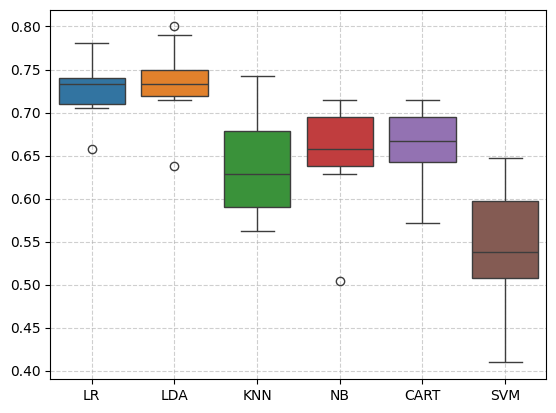

In [40]:
models = []
models.append(('LR',LogisticRegression(solver='liblinear')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('NB',GaussianNB()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVM',SVC()))
# Unpaking
result = []
names = []
for name , model in models:
    cv_result = cross_val_score(model ,x_resampled,y_resampled,cv=kfold,scoring=scoring)
    result.append(cv_result)
    names.append(name)
    print(f'Name : {name} , Accuracy : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
result_df = pd.DataFrame(result,index=names).T
sns.boxplot(data=result_df)
plt.grid(True,linestyle='--',alpha=0.6)
plt.show()

## 🔧 Standardization with Pipeline

A **Pipeline** connects the scaling step and the model into one organized process.  
This ensures that all preprocessing happens correctly and in the right order.

### 🎯 What It Does
1. Standardizes the numerical features  
2. Trains the model on the scaled data  

Using a Pipeline keeps the workflow clean, consistent, and ready for reliable model evaluation.

Name : LR , Accuracy : 73.62 % , STD : 4.11
Name : LDA , Accuracy : 73.52 % , STD : 4.23
Name : KNN , Accuracy : 68.38 % , STD : 4.68
Name : NB , Accuracy : 65.24 % , STD : 5.78
Name : CART , Accuracy : 65.81 % , STD : 4.94
Name : SVM , Accuracy : 73.05 % , STD : 4.22


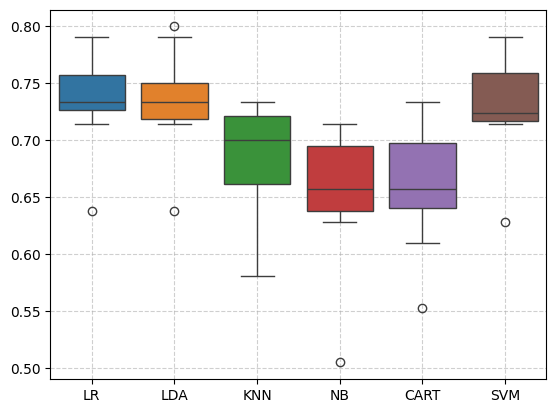

In [41]:
scaled_result = []
for name , model in models:
    pipeline = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    cv_scaled_result = cross_val_score(pipeline,x_resampled,y_resampled,cv=kfold,scoring=scoring)
    scaled_result.append(cv_scaled_result)
    print(f'Name : {name} , Accuracy : {cv_scaled_result.mean()*100:.2f} % , STD : {cv_scaled_result.std()*100:.2f}')
result_df = pd.DataFrame(scaled_result,index=names).T
sns.boxplot(data=result_df)
plt.grid(True,linestyle='--',alpha=0.6)
plt.show()

## 🗳 Voting Ensemble

Since our spot-check showed that LR, LDA, SVM, and **Random Forest** performed reasonably well,  
we move to a **Voting Ensemble** to combine their strengths and improve overall predictions.

### ⭐ How It Works
- Each base model (LR, LDA, SVM, Random Forest) votes for a class.  
- **Majority voting** determines the final prediction.  
- Can be **hard voting** (based on class labels) or **soft voting** (based on predicted probabilities).

### 🎯 Purpose
- Improve overall accuracy  
- Reduce the impact of individual model weaknesses  
- Leverage diversity among models (including Random Forest) for more robust predictions  
- Provide a stronger baseline before handling class imbalance or threshold tuning

In [48]:
# Define pipelines for base models
lr_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('LR',LogisticRegression(class_weight='balanced',max_iter=1000,penalty='l2',solver='lbfgs',random_state=random_state))
])
lda_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('LDA',LinearDiscriminantAnalysis(solver='lsqr'))
])
svm_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('SVM',SVC(probability=True,random_state=random_state))
])
rf_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('RF',RandomForestClassifier(class_weight='balanced'))
])
# Define hyperparameter grids for each model
lr_param_grid = {
    'LR__C' : [0.01,0.1,1,10]
}
lda_param_grid = {
    'LDA__shrinkage' : [None,0.1,0.5]
}
svm_param_grid = {
    'SVM__C' : [0.01,0.1,1,10],
    'SVM__kernel' : ['linear','rbf'],
    'SVM__gamma' : ['scale','auto']
}
rf_param_grid = {
    'RF__n_estimators' : [100,200,300],
    'RF__max_depth' : [None,3,5,10],
    'RF__min_samples_split' : [2,5,10],
    'RF__min_samples_leaf' : [1,2,4]
}
# GridSearchCV for each base model
lr_grid = GridSearchCV(estimator=lr_pipe,param_grid=lr_param_grid,scoring=scoring,cv=kfold)
lda_grid = GridSearchCV(estimator=lda_pipe,param_grid=lda_param_grid,scoring=scoring,cv=kfold)
svm_grid = GridSearchCV(estimator=svm_pipe,param_grid=svm_param_grid,scoring=scoring,cv=kfold)
rf_grid = GridSearchCV(estimator=rf_pipe,param_grid=rf_param_grid,scoring=scoring,cv=kfold)

lr_grid.fit(x_resampled,y_resampled)
lda_grid.fit(x_resampled,y_resampled)
svm_grid.fit(x_resampled,y_resampled)
rf_grid.fit(x_resampled,y_resampled)
# Build pipeline with Voting as final estimator
estimators = [
    ('LR',lr_grid.best_estimator_),
    ('LDA',lda_grid.best_estimator_),
    ('SVM',svm_grid.best_estimator_),
    ('RF',rf_grid.best_estimator_)
]
voting_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Voting',VotingClassifier(estimators=estimators,voting='soft'))
])
voting_param_grid = {
    'Voting__weights' : [None,(2,1,1,1),(1,2,1,1),(1,1,2,1),(1,1,1,2)]
}
voting_grid = GridSearchCV(
    estimator=voting_pipe,
    param_grid=voting_param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=kfold
)
voting_grid.fit(x_resampled,y_resampled)
print(f'VotingClassifier - Best CV accuracy : {voting_grid.best_score_*100:.2f} %')
print(f'VotingClassifier - Best params : {voting_grid.best_params_}')

VotingClassifier - Best CV accuracy : 73.81 %
VotingClassifier - Best params : {'Voting__weights': (1, 1, 1, 2)}


# 📝 Summary of Modeling Results So Far

Up to this point, we have completed several key steps:

- **Full data preprocessing**, including one-hot encoding and feature combination.  
- **Spot-checking baseline models** → Most models performed similarly (around **73%** accuracy).  
- **Standardization + Pipeline** → Did not noticeably improve model performance.  
- **VotingClassifier + GridSearchCV** → Best result remained around **73%**.  

### Why Accuracy Didn’t Improve
- The dataset likely has **limited predictive power**.  
- Different models learn **very similar patterns**.  
- Hyperparameters and voting weights **don’t significantly shift performance**.

---

# ➡️ Next Step: Move to the *Predict* Phase

In the next section, we will:

- Use the final model (Voting with the best params) to **predict on the test set**  
- Evaluate the predictions  
- Generate the confusion matrix, classification report, and final test accuracy  

This will show how well the model performs on **unseen, real-world data**.

In [65]:
voting_final_model = voting_grid.best_estimator_
prediction = voting_final_model.predict(x_test_final)
print(f'Test Accuracy : {accuracy_score(y_test,prediction)*100:.2f} %')
print('\n Confusion Matrix : \n',confusion_matrix(y_test,prediction))
print('\n Classification Report : \n',classification_report(y_test,prediction,zero_division=0))

Test Accuracy : 72.94 %

 Confusion Matrix : 
 [[158   1]
 [ 58   1]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.73      0.99      0.84       159
           1       0.50      0.02      0.03        59

    accuracy                           0.73       218
   macro avg       0.62      0.51      0.44       218
weighted avg       0.67      0.73      0.62       218



# 🏁 Final Summary

## 📊 Voting Classifier Results

- **Test Accuracy:** 72.94%
- **Confusion Matrix:**
[[158 1
, 58 1]]
- **Classification Report:**
- Class 0: precision=0.73, recall=0.99, f1=0.84
- Class 1: precision=0.50, recall=0.02, f1=0.03

## 🔹 What Happened

1. We built a **VotingClassifier** combining Logistic Regression, LDA, SVM, and **Random Forest**.  
2. Used **One-Hot Encoding** for categorical features and combined with numeric columns.  
3. Standard scaling was applied using a pipeline to normalize numeric data.  
4. **Hyperparameter tuning** of Voting weights and voting type was done with GridSearchCV.  
5. Although **Random Forest** was included, the model still favors the majority class due to imbalance.  

## ⚠️ Observations

- High overall accuracy is **misleading** because the model mainly predicts the majority class (0).  
- Class 1 (minority) is almost completely ignored → recall=0.02.  
- This happens due to **class imbalance**, where 0 dominates the dataset.  
- Random Forest contributed to ensemble diversity but did **not sufficiently improve minority detection**.  

## 🔹 Key Takeaways

- Accuracy alone is **not sufficient** for imbalanced data.  
- To improve minority class detection, we could:
- Use **SMOTENC** or other oversampling methods.
- Apply **threshold tuning** on `predict_proba` for class 1.
- Consider models or ensemble techniques sensitive to class imbalance (e.g., BalancedRandomForest).  
- This baseline shows that even with **Random Forest included**, careful handling of imbalance is crucial.

---

✅ **Conclusion:**  
This VotingClassifier baseline, including Random Forest, achieves high accuracy for the majority class but fails on the minority class due to imbalance. Future improvements should focus on balancing techniques, threshold adjustments, and model sensitivity for better minority detection.